In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("StressNotebook").getOrCreate()

df = spark.read.option("header", "true").option("inferSchema", "true").option("delimiter",";") \
    .csv("hdfs://localhost:9000/dataset/student/dataset-2.csv")

df.show(5)

print(type(df))

25/07/24 21:46:15 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.132 instead (on interface ens33)
25/07/24 21:46:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/24 21:46:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+----------------+----------------+-------------+-------------------+-------------------+---------------------+------------+------------------------+---------------------+----------------------------+-----------------+-------------+
|Student ID|Age|Gender|Academic Performance (GPA)|Study Hours Per Week|Social Media Usage (Hours per day)|Sleep Duration (Hours per night)|Physical Exercise (Hours per week)|Family Support  |Financial Stress|Peer Pressure|Relationship Stress|Mental Stress Level|Counseling Attendance|Diet Quality|Stress Coping Mechanisms|Cognitive Distortions|Family Mental Health History|Medical Condition|Substance Use|
+----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+--------------

In [5]:
from pyspark.sql.functions import avg, stddev, min, max
print(type(df))
#df = df.toDF(*[c.strip() for c in df.columns])

df.select(
    avg("Mental Stress Level").alias("Moyenne Stress"),
    stddev("Mental Stress Level").alias("Écart-type Stress"),
    min("Mental Stress Level").alias("Min Stress"),
    max("Mental Stress Level").alias("Max Stress"),
    avg("Sleep Duration (Hours per night)").alias("Moyenne Sommeil"),
    avg("Social Media Usage (Hours per day)").alias("Moyenne Réseaux"),
    avg("Academic Performance (GPA)").alias("Moyenne GPA")
).show()

df.groupBy("Gender").count().show()
print("Corrélation Stress ↔ Sommeil :", df.stat.corr("Mental Stress Level", "Sleep Duration (Hours per night)"))
print("Corrélation Stress ↔ Réseaux Sociaux :", df.stat.corr("Mental Stress Level", "Social Media Usage (Hours per day)"))
print("Corrélation GPA ↔ Sommeil :", df.stat.corr("Academic Performance (GPA)", "Sleep Duration (Hours per night)"))
df.groupBy("Gender").agg(avg("Mental Stress Level").alias("Stress moyen")).show()

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------------+------------------+----------+----------+-----------------+-----------------+-----------------+
|   Moyenne Stress| Écart-type Stress|Min Stress|Max Stress|  Moyenne Sommeil|  Moyenne Réseaux|      Moyenne GPA|
+-----------------+------------------+----------+----------+-----------------+-----------------+-----------------+
|6.287356321839081|2.3205941334960865|         1|        10|7.747126436781609|3.896551724137931|2.189655172413793|
+-----------------+------------------+----------+----------+-----------------+-----------------+-----------------+

+------+-----+
|Gender|count|
+------+-----+
|Female|   71|
|  Male|   77|
| Autre|   26|
+------+-----+

Corrélation Stress ↔ Sommeil : -0.07609381894907924
Corrélation Stress ↔ Réseaux Sociaux : 0.08302539375112415
Corrélation GPA ↔ Sommeil : 0.02107510546475076
+------+-----------------+
|Gender|     Stress moyen|
+------+-----------------+
|Female|5.971830985915493|
|  Male|6

In [6]:
print("Dimensions du dataset")
nb_lignes = df.count()
nb_colonnes = len(df.columns)
print(f"- Nombre de lignes : {nb_lignes}")
print(f"- Nombre de colonnes : {nb_colonnes}")

print("\nListe des colonnes")
print(df.columns)

Dimensions du dataset
- Nombre de lignes : 174
- Nombre de colonnes : 20

Liste des colonnes
['Student ID', 'Age', 'Gender', 'Academic Performance (GPA)', 'Study Hours Per Week', 'Social Media Usage (Hours per day)', 'Sleep Duration (Hours per night)', 'Physical Exercise (Hours per week)', 'Family Support  ', 'Financial Stress', 'Peer Pressure', 'Relationship Stress', 'Mental Stress Level', 'Counseling Attendance', 'Diet Quality', 'Stress Coping Mechanisms', 'Cognitive Distortions', 'Family Mental Health History', 'Medical Condition', 'Substance Use']


In [7]:
pdf = df.toPandas()

types_et_nulls = pd.DataFrame({
    "Type": pdf.dtypes,
    "Non nuls": pdf.notnull().sum(),
    "Nuls": pdf.isnull().sum()
})
print(types_et_nulls)
print(type(pdf))

                                      Type  Non nuls  Nuls
Student ID                           int32       174     0
Age                                  int32       174     0
Gender                              object       174     0
Academic Performance (GPA)           int32       174     0
Study Hours Per Week                 int32       174     0
Social Media Usage (Hours per day)   int32       174     0
Sleep Duration (Hours per night)     int32       174     0
Physical Exercise (Hours per week)   int32       174     0
Family Support                       int32       174     0
Financial Stress                     int32       174     0
Peer Pressure                        int32       174     0
Relationship Stress                  int32       174     0
Mental Stress Level                  int32       174     0
Counseling Attendance               object       174     0
Diet Quality                         int32       174     0
Stress Coping Mechanisms            object       174    

In [8]:
print("Statistiques descriptives des variables numériques")
print(pdf.describe())

Statistiques descriptives des variables numériques
       Student ID         Age  Academic Performance (GPA)  \
count  174.000000  174.000000                  174.000000   
mean    87.500000   24.022989                    2.189655   
std     50.373604    3.890041                    1.077198   
min      1.000000   17.000000                    0.000000   
25%     44.250000   21.000000                    2.000000   
50%     87.500000   23.000000                    2.000000   
75%    130.750000   27.000000                    3.000000   
max    174.000000   32.000000                    4.000000   

       Study Hours Per Week  Social Media Usage (Hours per day)  \
count            174.000000                          174.000000   
mean               8.000000                            3.896552   
std                6.614924                            2.705313   
min                0.000000                            0.000000   
25%                3.000000                            2.000000 

In [9]:
print("Valeurs uniques par colonne catégorielle")
cat_cols = pdf.select_dtypes(include="object").columns

for col in cat_cols:
    print(f"- {col} ({pdf[col].nunique()} valeurs uniques) : {pdf[col].unique()[:5]}")

Valeurs uniques par colonne catégorielle
- Gender (3 valeurs uniques) : ['Female' 'Male' 'Autre']
- Counseling Attendance (2 valeurs uniques) : ['No' 'Yes']
- Stress Coping Mechanisms (16 valeurs uniques) : ['Exercise' 'Sleeping' 'Cooking' 'Meditation' 'Watching Movies']
- Family Mental Health History (2 valeurs uniques) : ['No' 'Yes']
- Medical Condition (2 valeurs uniques) : ['No' 'Yes']


In [10]:
print("Distribution de 'Mental Stress Level'")
print(pdf["Mental Stress Level"].value_counts().sort_index())

Distribution de 'Mental Stress Level'
Mental Stress Level
1      4
2      5
3     12
4     27
5     11
6     33
7     21
8     30
9     14
10    17
Name: count, dtype: int64


/tmp/ipykernel_52514/3345161867.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="Mental Stress Level", palette="coolwarm")


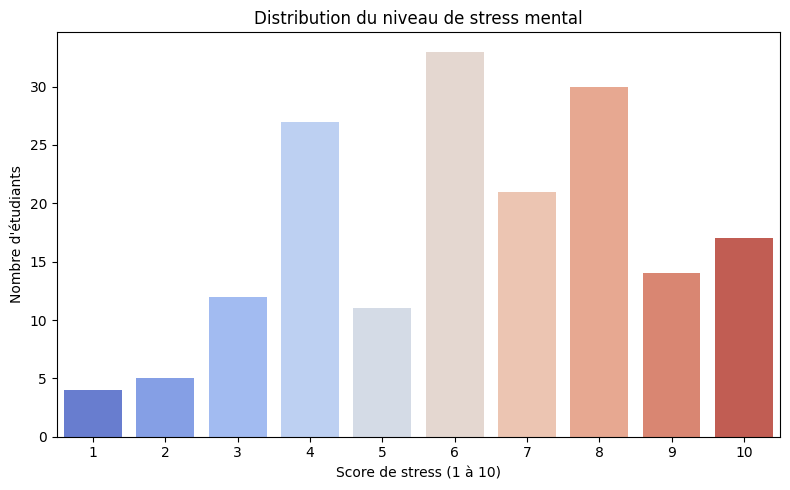

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=pdf, x="Mental Stress Level", palette="coolwarm")
plt.title("Distribution du niveau de stress mental")
plt.xlabel("Score de stress (1 à 10)")
plt.ylabel("Nombre d'étudiants")
plt.tight_layout()
plt.show()

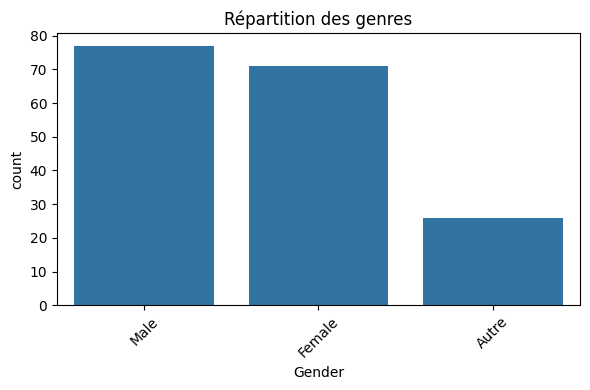

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=pdf, x="Gender", order=pdf["Gender"].value_counts().index)
plt.title("Répartition des genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

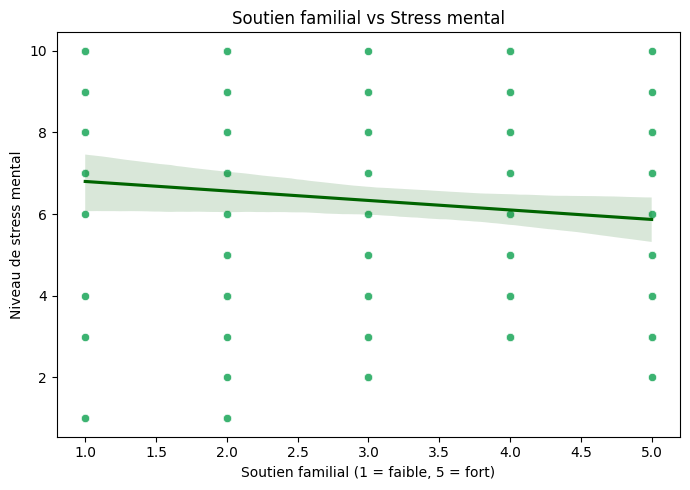

Corrélation entre le soutien familial et le stress : -0.13


In [13]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pdf, x="Family Support  ", y="Mental Stress Level", color="mediumseagreen")
sns.regplot(data=pdf, x="Family Support  ", y="Mental Stress Level", scatter=False, color="darkgreen")
plt.title("Soutien familial vs Stress mental")
plt.xlabel("Soutien familial (1 = faible, 5 = fort)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Family Support  "].corr(pdf["Mental Stress Level"])
print(f"Corrélation entre le soutien familial et le stress : {correlation:.2f}")

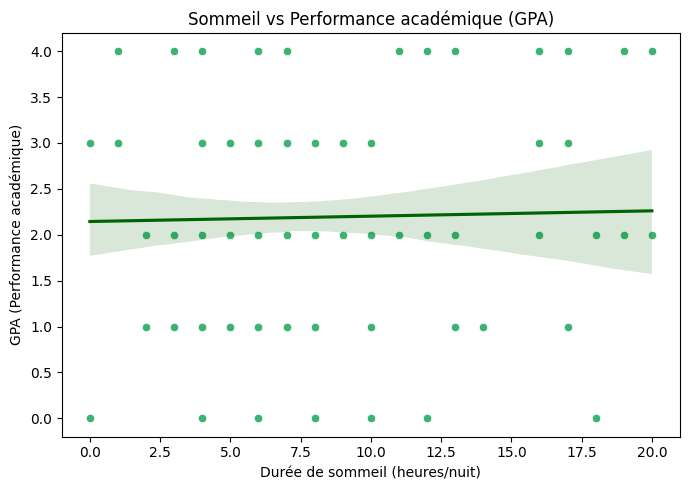

Corrélation Sommeil ↔ GPA : 0.02


In [14]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()

correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

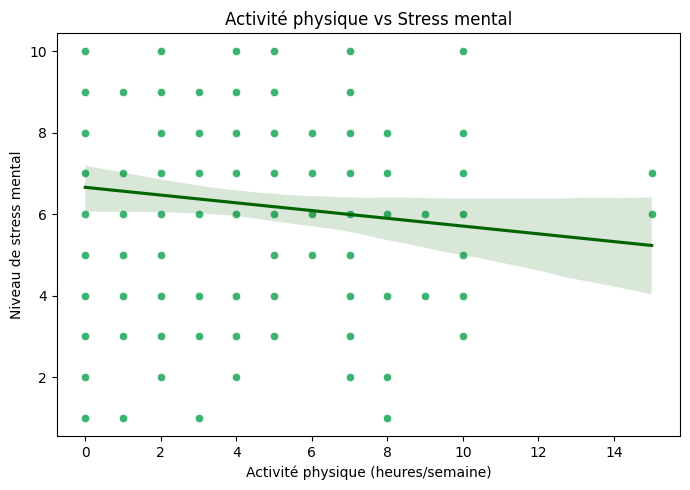

Corrélation Activité physique ↔ Stress mental : -0.13


In [15]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Physical Exercise (Hours per week)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Activité physique vs Stress mental")
plt.xlabel("Activité physique (heures/semaine)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Physical Exercise (Hours per week)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Activité physique ↔ Stress mental : {correlation:.2f}")


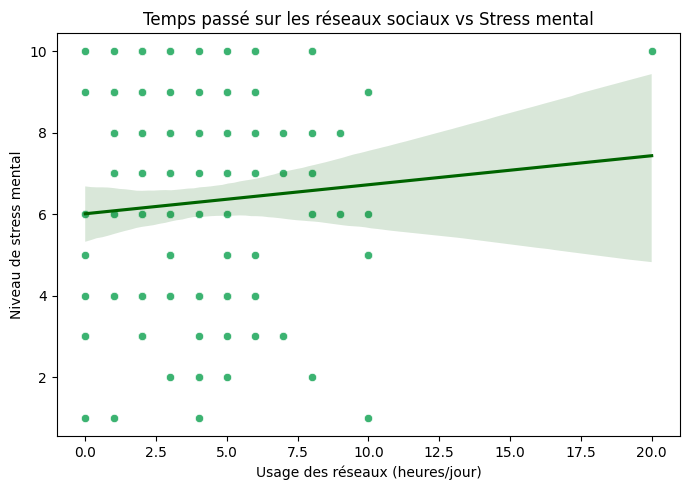

Corrélation Réseaux Sociaux ↔ Stress mental : 0.08


In [16]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Social Media Usage (Hours per day)",
    y="Mental Stress Level",
    scatter=False,
    color="darkgreen"
)
plt.title("Temps passé sur les réseaux sociaux vs Stress mental")
plt.xlabel("Usage des réseaux (heures/jour)")
plt.ylabel("Niveau de stress mental")
plt.tight_layout()
plt.show()

correlation = pdf["Social Media Usage (Hours per day)"].corr(pdf["Mental Stress Level"])
print(f"Corrélation Réseaux Sociaux ↔ Stress mental : {correlation:.2f}")

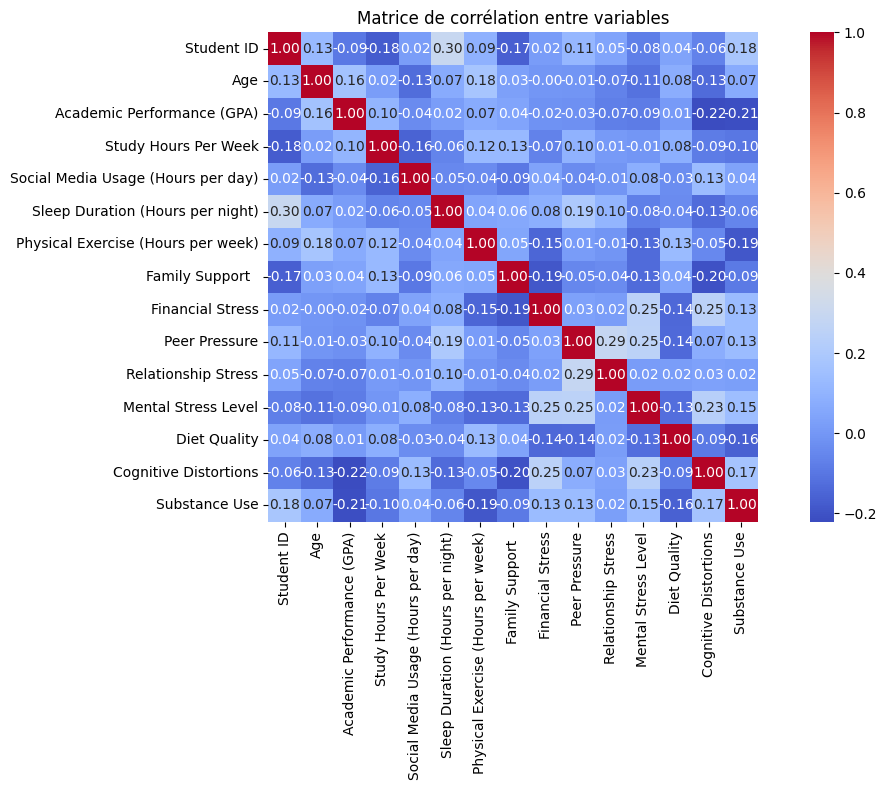

In [17]:
correlation_matrix = pdf.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation entre variables")
plt.tight_layout()
plt.show()

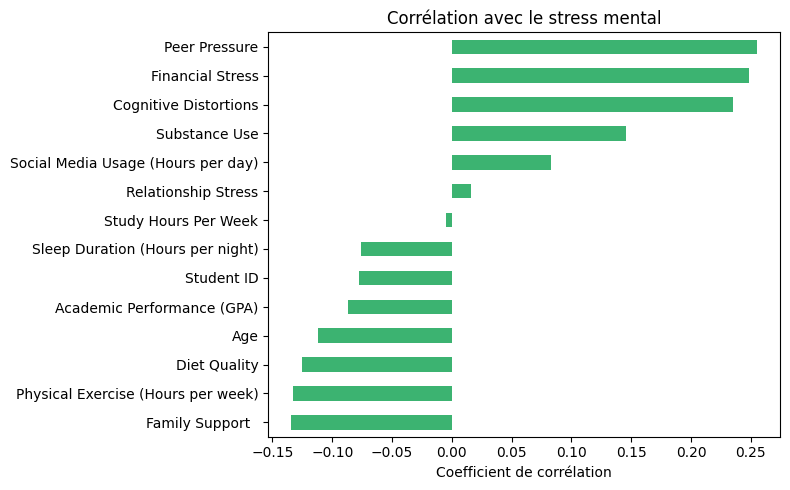

In [18]:
cor_stress = correlation_matrix["Mental Stress Level"].drop("Mental Stress Level")

plt.figure(figsize=(8, 5))
cor_stress.sort_values().plot(kind='barh', color='mediumseagreen')
plt.title("Corrélation avec le stress mental")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()

Gender                    Autre  Female  Male
Stress Coping Mechanisms                     
Cooking                       1       2     0
Exercise                      3       9    23
Exercise                      0       0     1
Meditation                    0       3     4
Meditation                    0       1     0
Playing Video Games           7       3    11
Reading                       3      14     7
Sleeping                      7       5     0
Social Media Engagement       1       6     5
Spending Time Alone           0       1     2
Talking to Friends            1      17    12
Travelling                    3       3     2
Walking or Nature Walks       0       5     6
Watching Movies               0       1     3
Watching Sports               0       0     1
Yoga                          0       1     0


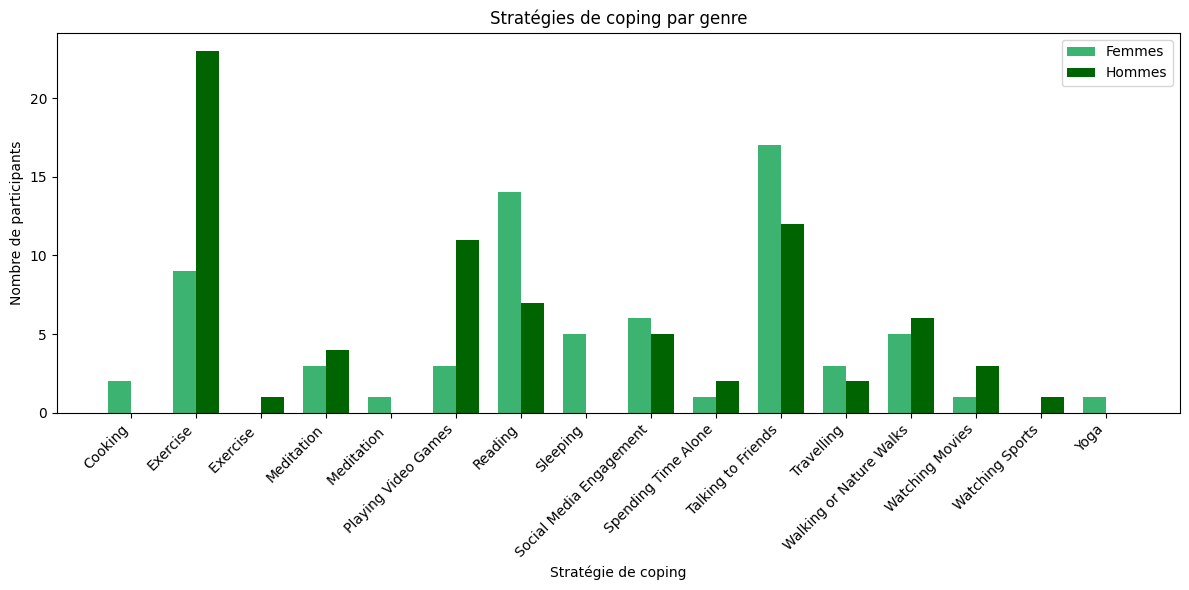

In [19]:
coping_table = pd.crosstab(pdf["Stress Coping Mechanisms"], pdf["Gender"])
print(coping_table)

strategies = coping_table.index.tolist()
x = np.arange(len(strategies))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, coping_table["Female"], width, label='Femmes', color='mediumseagreen')
plt.bar(x + width/2, coping_table["Male"], width, label='Hommes', color='darkgreen')

plt.xticks(x, strategies, rotation=45, ha='right')
plt.title("Stratégies de coping par genre")
plt.xlabel("Stratégie de coping")
plt.ylabel("Nombre de participants")
plt.legend()
plt.tight_layout()
plt.show()

Corrélation Sommeil ↔ GPA : 0.02


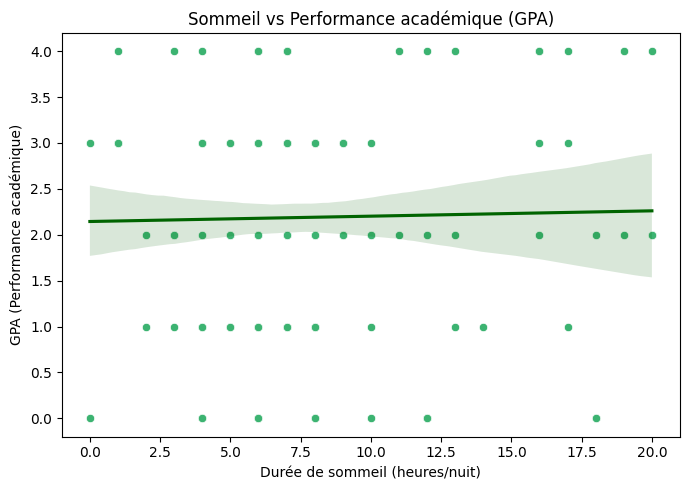

In [20]:
correlation = pdf["Sleep Duration (Hours per night)"].corr(pdf["Academic Performance (GPA)"])
print(f"Corrélation Sommeil ↔ GPA : {correlation:.2f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    color="mediumseagreen"
)
sns.regplot(
    data=pdf,
    x="Sleep Duration (Hours per night)",
    y="Academic Performance (GPA)",
    scatter=False,
    color="darkgreen"
)
plt.title("Sommeil vs Performance académique (GPA)")
plt.xlabel("Durée de sommeil (heures/nuit)")
plt.ylabel("GPA (Performance académique)")
plt.tight_layout()
plt.show()

→ k optimum = 5, score = 0.1668


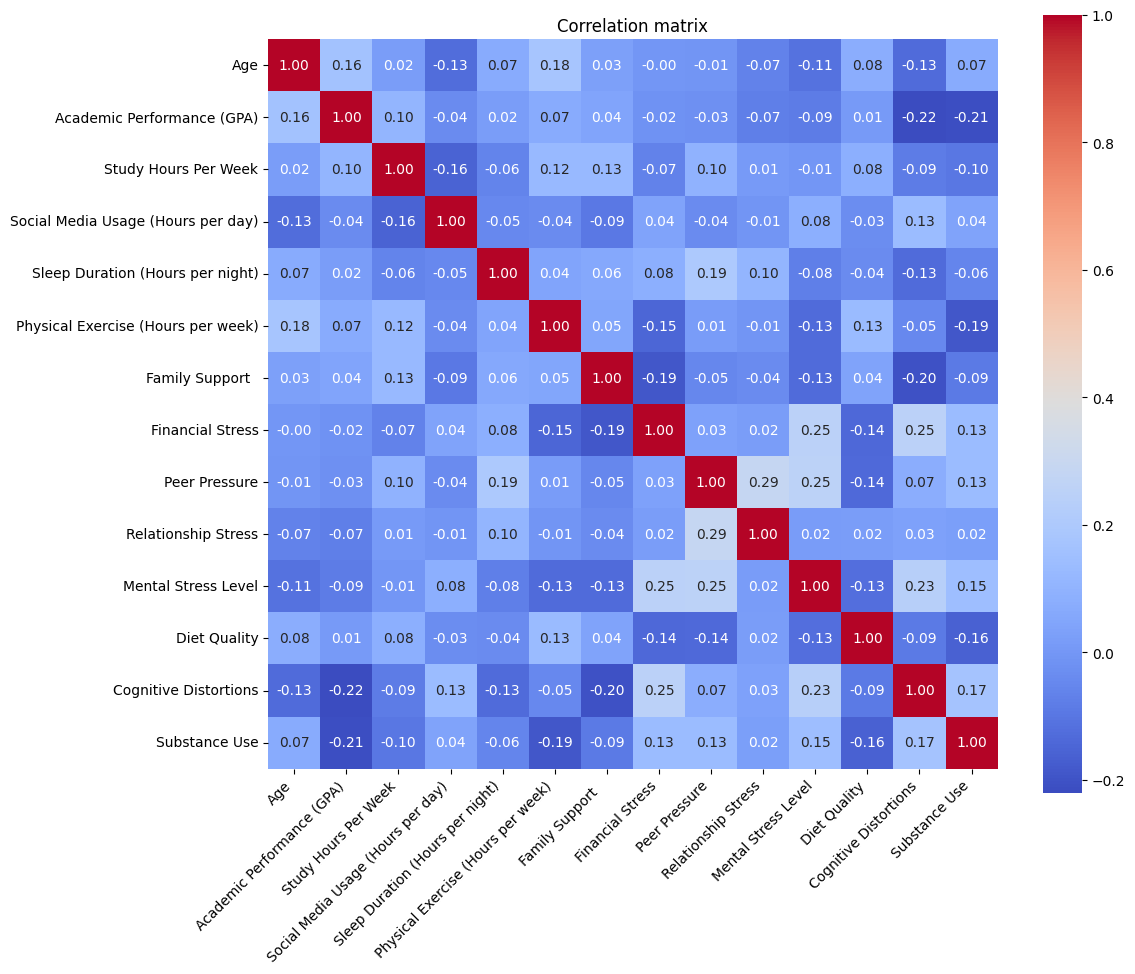


---Cluster Correlation 2 ---


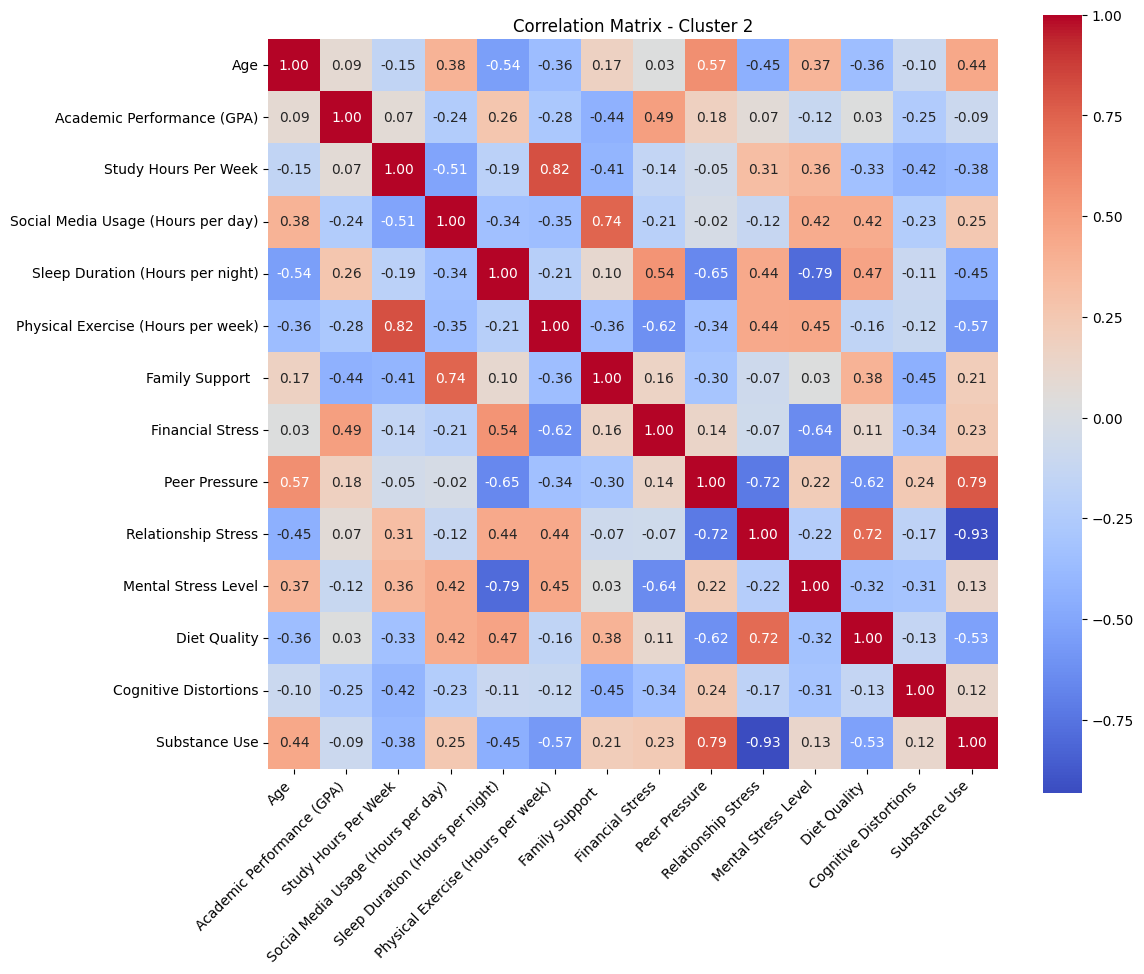


---Cluster Correlation 4 ---


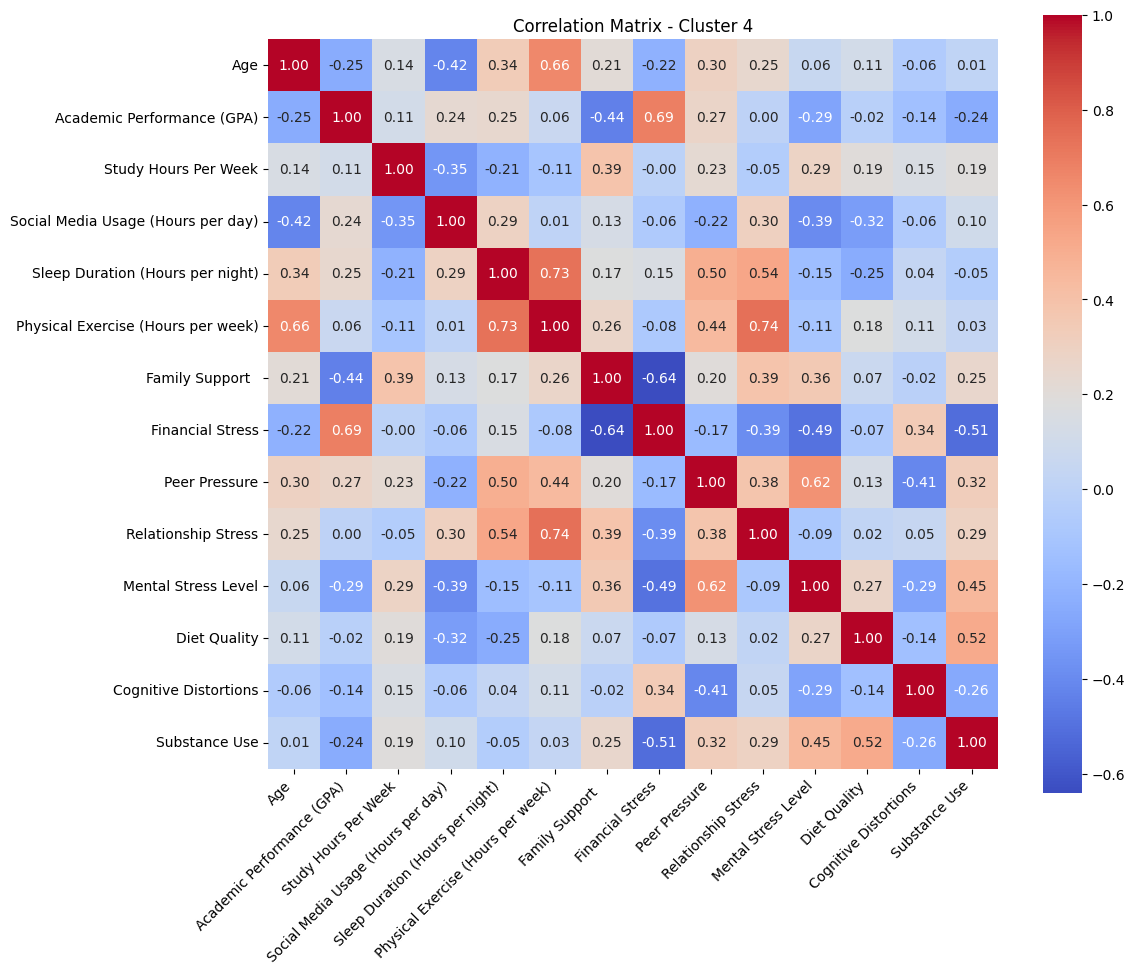

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler,
    StringIndexer, OneHotEncoder
)
from builtins import max
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns


#Split between numeric and string Column
numeric_cols = [
    "Age",
    "Academic Performance (GPA)",
    "Study Hours Per Week",
    "Social Media Usage (Hours per day)",
    "Sleep Duration (Hours per night)",
    "Physical Exercise (Hours per week)",
    "Family Support  ",
    "Financial Stress",
    "Peer Pressure",
    "Relationship Stress",
    "Mental Stress Level",
    "Diet Quality", 
    "Cognitive Distortions",
    "Substance Use"
]

string_cols = [
    "Gender",
    "Counseling Attendance",
    "Stress Coping Mechanisms",
    "Family Mental Health History",
    "Medical Condition"
]

#Change the String to binary value ex male = 1
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in string_cols
]
#convert the value to a tab for example male = [0.0, 1.0, 0.0] and female = [1.0, 0.0, 0.0]
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
    for col in string_cols
]

#Regroup the features spliited earlier to a Vector one-hot encoded

assembler_inputs = numeric_cols + [f"{c}_ohe" for c in string_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw")

#Standardisation, convert mean to 0 and standard deviation to 0 (écart-type)
scaler = StandardScaler(
    inputCol="features_raw", outputCol="features",
    withMean=True, withStd=True
)

#Tranformation piepline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
model_pipeline = pipeline.fit(df)
df_prepared = model_pipeline.transform(df)

# Best k-mean research 
evaluator = ClusteringEvaluator(
    featuresCol="features",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)
#silouhette score
sil_scores = []

#find the best cluster
for k in range(2, 11):
    km = KMeans(featuresCol="features", k=k, seed=42)
    km_model = km.fit(df_prepared)
    preds = km_model.transform(df_prepared)
    score = evaluator.evaluate(preds)
    sil_scores.append((k, score))
    #print(f"Silhouette pour k={k}: {score:.4f}")

#Best score of k
k_optimal, best_score = max(sil_scores, key=lambda x: x[1])
print(f"→ k optimum = {k_optimal}, score = {best_score:.4f}")

#Final train and added the cluster to a column
final_km = KMeans(featuresCol="features", k=k_optimal, seed=42)
final_model = final_km.fit(df_prepared)
df_clustered = final_model.transform(df_prepared).withColumnRenamed("prediction", "cluster")


#Convert pyspark dataframe to pandas
pdf = df_clustered.select(numeric_cols + ["cluster"]).toPandas()

#Global correlation
global_corr = pdf[numeric_cols].corr()
#print("Global correlation matrix:")
#print(global_corr)

# Global eatmap correlation
plt.figure(figsize=(12, 10))
sns.heatmap(global_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Correlation by clusters
for cluster in sorted(pdf["cluster"].unique()):
    if (cluster == 2 or cluster == 4 ):
        print(f"\n---Cluster Correlation {cluster} ---")
        sub_df = pdf[pdf["cluster"] == cluster][numeric_cols]
        
        corr = sub_df.corr()
    #    print(corr)

        # Heatmap for the clusters
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title(f"Correlation Matrix - Cluster {cluster}")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


In [ ]:
cluster_means = pdf.groupby("cluster")[numeric_cols].mean()

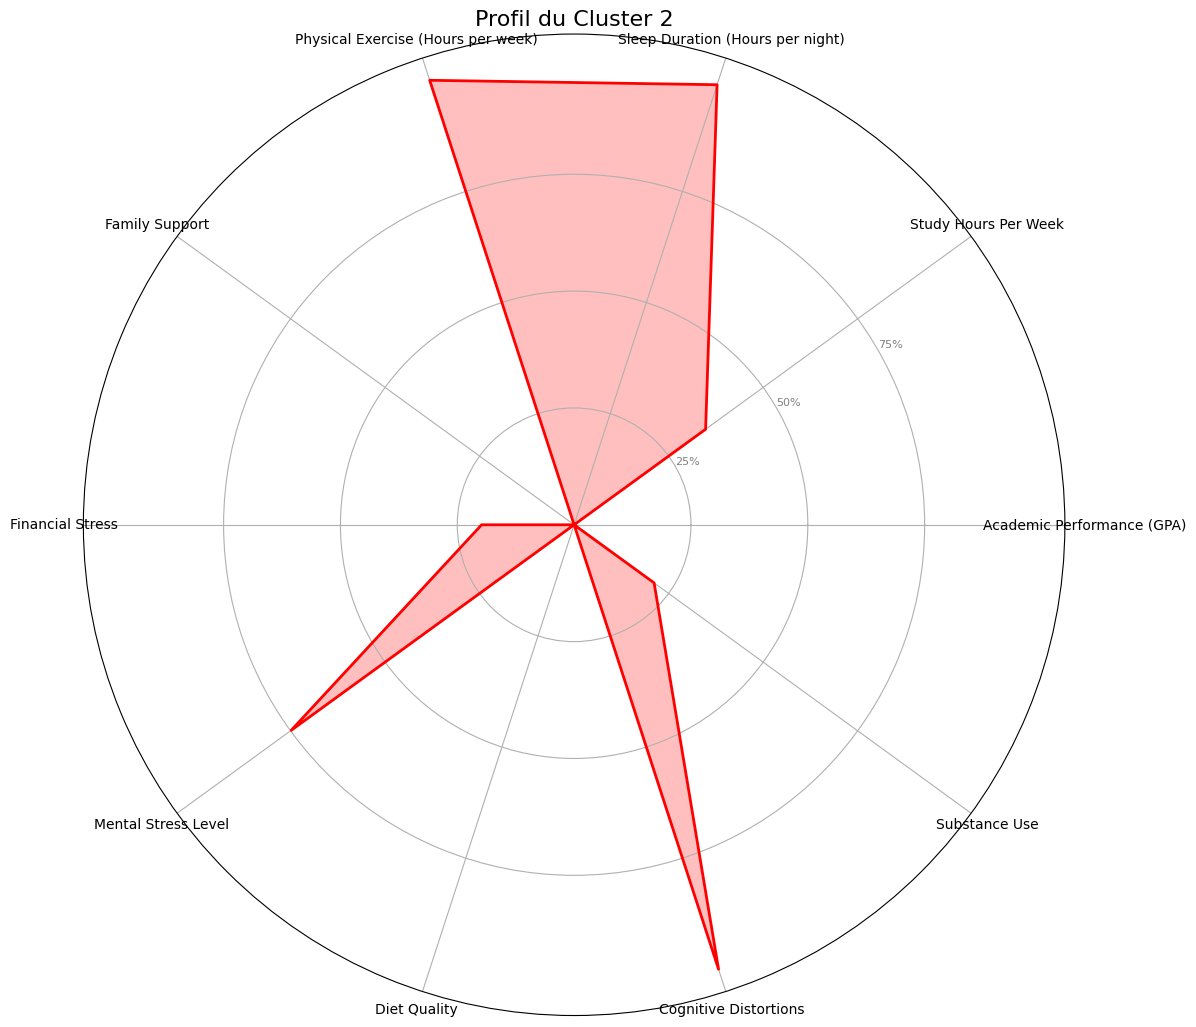

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    "Academic Performance (GPA)", "Study Hours Per Week", "Sleep Duration (Hours per night)",
    "Physical Exercise (Hours per week)", "Family Support  ",
    "Financial Stress", "Mental Stress Level", "Diet Quality",
    "Cognitive Distortions", "Substance Use"
]

#cluster 2 values
cluster_vals = cluster_means.loc[2, variables].values

#Values normalization
min_vals = cluster_means[variables].min().values
max_vals = cluster_means[variables].max().values
scaled_vals = (cluster_vals - min_vals) / (max_vals - min_vals)

#Grap preparation
labels = variables
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
scaled_vals = np.concatenate((scaled_vals, [scaled_vals[0]]))
angles += [angles[0]]

#ploting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
ax.plot(angles, scaled_vals, color="red", linewidth=2)
ax.fill(angles, scaled_vals, color="red", alpha=0.25)
ax.set_rlabel_position(30)

ax.set_title("Profil du Cluster 2", fontsize=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
plt.tight_layout()
plt.show()


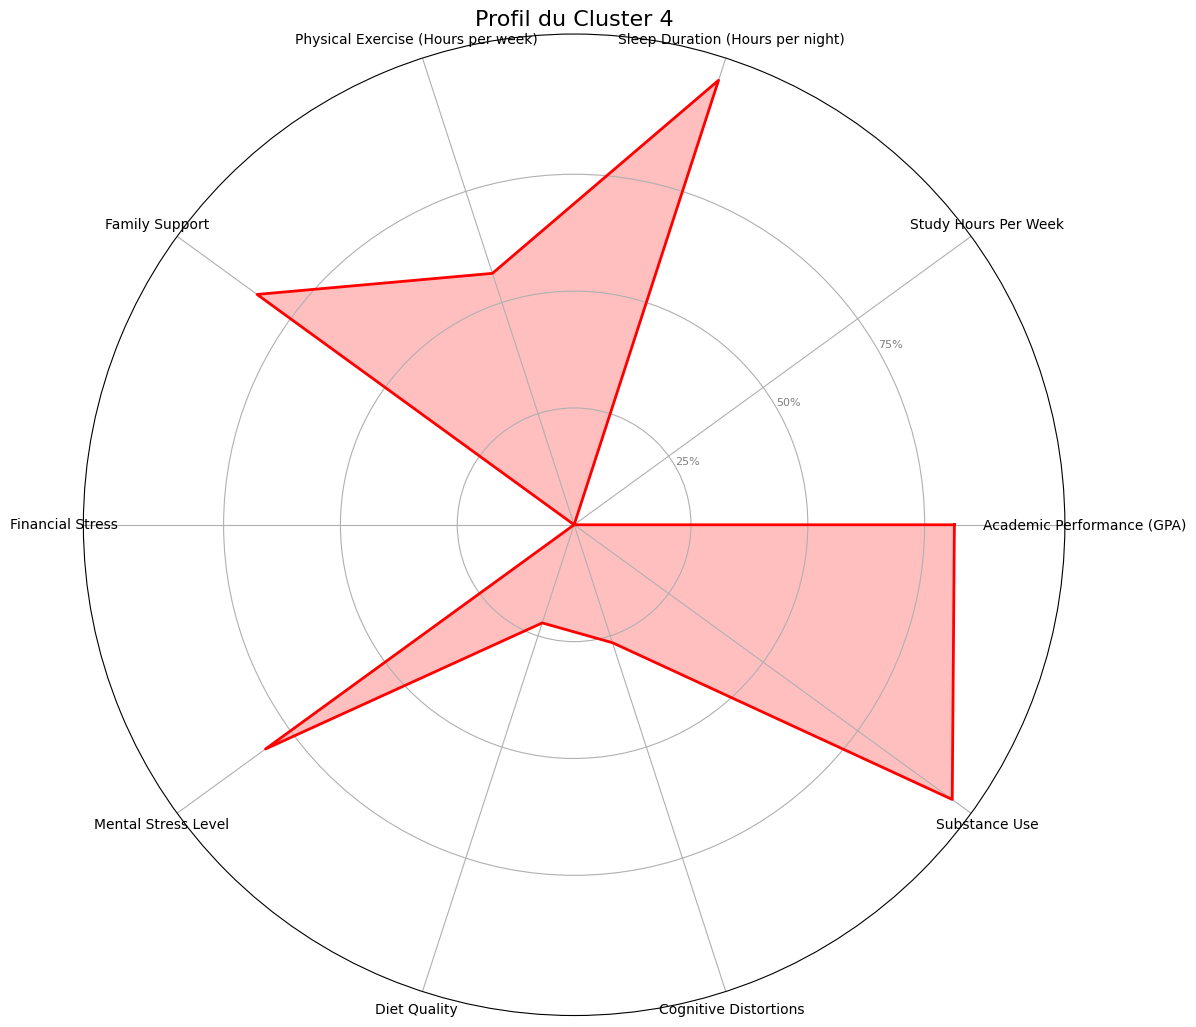

In [ ]:
cluster_vals = cluster_means.loc[4, variables].values

#Values normalization
min_vals = cluster_means[variables].min().values
max_vals = cluster_means[variables].max().values
scaled_vals = (cluster_vals - min_vals) / (max_vals - min_vals)

#Graph
labels = variables
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
scaled_vals = np.concatenate((scaled_vals, [scaled_vals[0]]))  
angles += [angles[0]]

#Plotting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
ax.plot(angles, scaled_vals, color="red", linewidth=2)
ax.fill(angles, scaled_vals, color="red", alpha=0.25)
ax.set_rlabel_position(30)

ax.set_title("Profil du Cluster 4", fontsize=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
plt.tight_layout()
plt.show()

Nombre total de colonnes après encodage : 19
   Gender_ohe  Counseling Attendance_ohe  Family Mental Health History_ohe  \
0   -0.888399                   1.200986                          0.741883   
1    1.119152                  -0.827864                          0.741883   
2    1.119152                  -0.827864                          0.741883   
3   -0.888399                   1.200986                         -1.340175   
4   -0.888399                   1.200986                          0.741883   
5   -0.888399                   1.200986                         -1.340175   
6    1.119152                  -0.827864                         -1.340175   
7    1.119152                  -0.827864                          0.741883   
8    1.119152                  -0.827864                          0.741883   
9   -0.888399                   1.200986                          0.741883   

   cluster  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6    